# VGG

- AlexNet 比LeNet 更深更大来得到更好的精度
- 能否更大更深？
- 选项：
    - 更多的全连接层（太贵）
    - 更多的卷积层
    - 将卷积层组合成块
- 主要改进：
    - 把AlexNet（相对于LeNet）新加入的卷积层，替换成VGG块

## VGG 块

- 深 vs. 宽？
    - 5x5卷积
        - 计算量大，导致网络浅
    - 3x3卷积
        - 模型更深但kernel窗口更窄（小），效果更好
- VGG 块
    - 用大量的3 x 3卷积（填充1）堆砌起来
        - （n层，m通道）
    - 2 x 2最大池化层（步幅2）
    <img src="./pic/VGG块.PNG" width=400 height=400>

## VGG 架构
- 多个VGG块后，接全连接层
- 不同次数的重复块，得到不同的架构
    - VGG-16
        - 13个卷积层 + 3个全连接层
    - VGG-19
    
## 进度
- LeNet(1995)
    - 2卷积层 + 池化层
    - 2全连接层
- AlexNet
    - 更大更深
    - ReLu，Dropout，数据增强
 
- VGG
    - 更大更深的AlexNet（重复的VGG块）
    
<img src="./pic/进度.png" width=400 height=400>


## 总结

- VGG使用可重复使用的卷积块来构建深度卷积神经网络
- 不同的卷积块个数和超参数可以得到不同复杂度的变种

# 代码实现 - 使用VGG块的神经网络

In [2]:
import torch
from torch import nn
from d2l import torch as d2l

# VGG块
def vgg_block(num_convs, in_channels, out_channels):
    # num_convs需要多少个卷积层
    layers = []
    for _ in range(num_convs):    # 下划线相当于变量名(省略)  你也可以用 i
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)    # 把列表里面的元素按顺序作为参数输入函数

In [3]:
# 分为5大块，每一块高宽减半，因为有maxpooling
# 224 除以(5次)2，等于【7】。因为输入是224，最多做5次块，输出为【7】
# 所以7x7为最后卷积层的图像输出大小
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

# 8个卷积层，3层全连接，共11层
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # 全连接层部分
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

In [4]:
X = torch.randn(size=(1, 1, 224, 224))
for blk in net:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)
    
# Q：打印层的尺寸时，我们只看到8个结果，而不是11个结果。剩余的3层信息去哪了？
# A：输出只看Sequential和Linear是8层：5层Sequential和3层Linear
# 后三层的卷积层(Sequential)，2个卷积看成了一个块，所以只看8层

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


C:\Users\Tyler\anaconda3\envs\pytorch19\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [5]:
### 由于VGG-11比AlexNet计算量更大，因此我们构建了一个通道数较少的网络，足够用于训练Fashion-MNIST数据集

In [6]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
net = vgg(small_conv_arch)

loss 0.187, train acc 0.931, test acc 0.918
1048.9 examples/sec on cuda:0


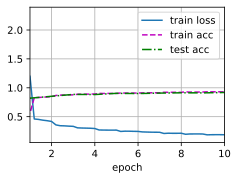

In [7]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())